#### RFM Segmentation
- Recency - which measures how recent was each customer's last purchase. days since last customer transaction. the lower the better. 
-  Frequency - which measures how many purchases the customer has done in the last 12 months
-  MonetaryValue - measures how much has the customer spent in the last 12 months. We will use these values to assign customers to RFM segments.

Grouping RFM values to assign a percentile to a metric, and then create a label to be used for segmentation.

Process of calculating percentiles: 
- sort customers based on that metric
- break customers into predefined number of groups of equal size
- Asign a label to each group 


calculating percentiles qcut()

In [2]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
#library to connect to red shift 
import psycopg2 
import os 



#to supress any warnings 
import warnings
warnings.filterwarnings('ignore')



In [3]:
from dotenv import load_dotenv
load_dotenv()

dbname = os.getenv('dbname')
host = os.getenv('host')

port = os.getenv('port')
user = os.getenv('user')
password = os.getenv('password')


In [4]:
# connect to redshift
def connect_to_redshift (dbname, host, port, user, password): 
    connect = psycopg2.connect(dbname=dbname, host=host, port=port, user=user, password=password)
    print('connection to redshift made') 
    return connect
    
    

In [5]:
connect = connect_to_redshift(dbname, host, port, user, password)

connection to redshift made


In [6]:
query = ''' select * 
            from bootcamp.online_transactions_cleaned'''

customer_data = pd.read_sql(query, connect)           

In [7]:
# grouping columns by customers_id in uk 

data_uk = customer_data[customer_data['country']== 'United Kingdom']

In [8]:
customer_uk = data_uk.groupby('customer_id').agg({
    'invoice':'nunique', # unique invoices per customer
    'stock_code': 'nunique', #unique stock code per customer 
    'quantity': 'sum', #sum of quantities per customer 
    'price': 'mean', #average price of items per customer 
    'invoice_date': 'max', # last invoice date per customer
    'total_order_value': 'sum'# sum of orders per customer
}).reset_index()

In [9]:
customer_uk

,customer_id,invoice,stock_code,quantity,price,invoice_date,total_order_value
0,u12346,2,1,0,1.040000,2011-01-18 10:17:00,0.00
1,u12747,11,42,1275,4.367864,2011-12-07 14:34:00,4196.01
2,u12748,217,1767,23516,2.377500,2011-12-09 12:20:00,29819.99
3,u12749,8,160,1422,5.071429,2011-12-06 09:56:00,3868.20
4,u1282,4,55,722,1.904746,2011-12-06 15:12:00,942.34
...,...,...,...,...,...,...,...
3938,u1828,1,10,45,4.765000,2011-03-07 09:52:00,180.60
3939,u18281,1,7,54,5.622857,2011-06-12 10:53:00,80.82
3940,u18282,3,12,98,4.821538,2011-12-02 11:43:00,176.60
3941,u18283,16,262,1355,1.625007,2011-12-06 12:02:00,2039.58


In [10]:
customer_uk= customer_uk.rename(columns={
    "invoice": "frequency", # how many invoices per customer
    "stock_code": "stock_code_unique", # how many stock codes per customer
    "quantity": "quantity_total", # how many items each customer ordered in totaL
    "price": "average_price_per_customer", # average price per customer
    "invoice_date": "recent_invoice_date",# last time customer was seen making a purchase
    "total_order_value": "monetary_value" # monetary value of each customer
})
customer_uk.head()

,customer_id,frequency,stock_code_unique,quantity_total,average_price_per_customer,recent_invoice_date,monetary_value
0,u12346,2,1,0,1.040000,2011-01-18 10:17:00,0.00
1,u12747,11,42,1275,4.367864,2011-12-07 14:34:00,4196.01
2,u12748,217,1767,23516,2.377500,2011-12-09 12:20:00,29819.99
3,u12749,8,160,1422,5.071429,2011-12-06 09:56:00,3868.20
4,u1282,4,55,722,1.904746,2011-12-06 15:12:00,942.34


In [11]:
customer_uk.describe()

,frequency,stock_code_unique,quantity_total,average_price_per_customer,recent_invoice_date,monetary_value
count,3943.000000,3943.000000,3943.000000,3943.000000,3943,3943.000000
mean,4.966523,60.475273,1012.513822,3.519806,2011-09-09 00:39:22.642657792,1728.474535
min,1.000000,1.000000,-303.000000,0.000000,2010-12-01 09:53:00,-1192.200000
25%,1.000000,15.000000,147.500000,2.165643,2011-07-18 23:39:00,283.590000
50%,3.000000,35.000000,355.000000,2.862143,2011-10-20 19:15:00,626.090000
75%,5.000000,77.000000,924.000000,3.750997,2011-11-23 09:15:30,1520.295000
max,217.000000,1767.000000,69021.000000,327.225000,2011-12-09 12:49:00,259657.300000
std,8.479952,81.677559,3198.920543,8.106255,NaN,6664.878209


In [12]:
customer_uk[customer_uk['monetary_value']<0].count()

customer_id                   31
frequency                     31
stock_code_unique             31
quantity_total                31
average_price_per_customer    31
recent_invoice_date           31
monetary_value                31
dtype: int64

In [13]:
#Only 31 negative values, lets drop them 

customer_uk= customer_uk[customer_uk['monetary_value']>0]

In [14]:
#add recency column 

current_date= customer_uk['recent_invoice_date'].max()
current_date

Timestamp('2011-12-09 12:49:00')

In [15]:
customer_uk['recency']= (current_date - customer_uk['recent_invoice_date']).dt.days

In [16]:
#New dataframe with frequency, recency and monetary values per Customer

rfm= customer_uk[['customer_id','recency','frequency','monetary_value']].round(2)
rfm

,customer_id,recency,frequency,monetary_value
1,u12747,1,11,4196.01
2,u12748,0,217,29819.99
3,u12749,3,8,3868.20
4,u1282,2,4,942.34
5,u12821,213,1,92.72
...,...,...,...,...
3938,u1828,277,1,180.60
3939,u18281,180,1,80.82
3940,u18282,7,3,176.60
3941,u18283,3,16,2039.58


In [17]:
rfm['monetary_value'].sort_values(ascending=False)
#purchases +2M $ 

3804    259657.30
3334    189575.53
3376     88138.20
2784     65920.12
908      65164.79
          ...    
2621         5.90
2825         3.75
2615         2.90
3934         0.00
1244         0.00
Name: monetary_value, Length: 3907, dtype: float64

In [18]:
# let's see the Median 
rfm['monetary_value'].median()
# Median is 600 dollars, purchases of worth of millions seems like outliers
#however it might be the outliers are segmented in another data frame as premium Customers  

632.97

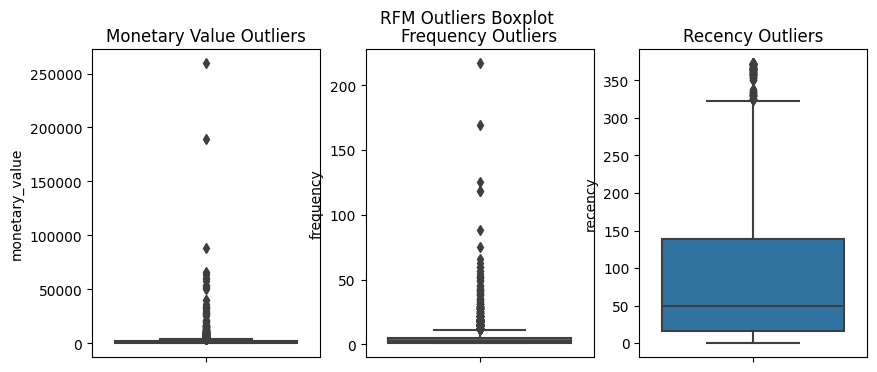

In [19]:
#let's visualise outliers
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
fig.suptitle('RFM Outliers Boxplot')
sns.boxplot(y=rfm["monetary_value"], ax=ax1)
ax1.set_title("Monetary Value Outliers")
sns.boxplot(y=rfm["frequency"], ax=ax2)
ax2.set_title("Frequency Outliers")
sns.boxplot(y=rfm["recency"], ax=ax3)
ax3.set_title("Recency Outliers")
plt.show()

In [20]:
#remove outliers with IQR method 

def remove_outliers_iqr(df, column):
    Q1= df[column].quantile(0.25)
    Q3= df[column].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df.loc[(df[column] < Q1 - 1.5*IQR) | (df[column] > Q3 + 1.5*IQR)]
    return df.drop(outliers.index) 

In [21]:
#apply the function to remove outliers from each column 
customers_no_outliers = remove_outliers_iqr(rfm, 'frequency') 

In [22]:
customers_no_outliers

,customer_id,recency,frequency,monetary_value
1,u12747,1,11,4196.01
3,u12749,3,8,3868.20
4,u1282,2,4,942.34
5,u12821,213,1,92.72
6,u12822,70,3,918.98
...,...,...,...,...
3937,u18278,73,1,173.90
3938,u1828,277,1,180.60
3939,u18281,180,1,80.82
3940,u18282,7,3,176.60


In [23]:
customers_no_outliers = remove_outliers_iqr(rfm,'recency') 

In [24]:
customers_no_outliers = remove_outliers_iqr(rfm,'monetary_value') 

In [25]:
customers_no_outliers

,customer_id,recency,frequency,monetary_value
4,u1282,2,4,942.34
5,u12821,213,1,92.72
6,u12822,70,3,918.98
7,u12823,74,5,1759.50
8,u12824,59,1,397.12
...,...,...,...,...
3938,u1828,277,1,180.60
3939,u18281,180,1,80.82
3940,u18282,7,3,176.60
3941,u18283,3,16,2039.58


In [26]:
customers_no_outliers.describe()

,recency,frequency,monetary_value
count,3530.000000,3530.000000,3530.000000
mean,96.646459,3.377054,824.570649
std,100.557365,3.082834,763.771762
min,0.000000,1.000000,0.000000
25%,20.000000,1.000000,264.627500
50%,56.000000,2.000000,547.030000
75%,155.750000,4.000000,1141.162500
max,373.000000,39.000000,3385.620000


In [27]:
customers_no_outliers= customers_no_outliers.reset_index(drop=True)

In [28]:
# Recency quartile 
r_labels = range(4,0,-1)
r_quartiles = pd.qcut(customers_no_outliers['recency'], 4, labels = r_labels)
customers_no_outliers = customers_no_outliers.assign( r = r_quartiles.values)


In [31]:
f_labels = range(1,5)
m_labels = range(1,5)
# used .rank(method='first') to get around error non unique bin edges error
f_quartiles = pd.qcut(customers_no_outliers['frequency'].rank(method='first'), 4, labels = f_labels)
m_quartiles = pd.qcut(customers_no_outliers['monetary_value'], 4, labels = m_labels)
customers_no_outliers = customers_no_outliers.assign(f = f_quartiles.values)
customers_no_outliers = customers_no_outliers.assign(m = m_quartiles.values)

In [30]:
customers_no_outliers

,customer_id,recency,frequency,monetary_value,r,F,M
0,u1282,2,4,942.34,4,3,3
1,u12821,213,1,92.72,1,1,1
2,u12822,70,3,918.98,2,3,3
3,u12823,74,5,1759.50,2,4,4
4,u12824,59,1,397.12,2,1,2
...,...,...,...,...,...,...,...
3525,u1828,277,1,180.60,1,2,1
3526,u18281,180,1,80.82,1,2,1
3527,u18282,7,3,176.60,4,3,1
3528,u18283,3,16,2039.58,4,4,4


In [32]:
#RFM Segment by concatenating the RFM quartiles 
# RFM Score by summing the quartiles

def join_rfm(x): return str(x['r']) + str(x['f']) + str(x['m'])


In [33]:
customers_no_outliers['rfm_segment'] = customers_no_outliers.apply(join_rfm, axis=1)
customers_no_outliers['rfm_score'] = customers_no_outliers[['r', 'f', 'm']].sum(axis=1)

In [34]:
customers_no_outliers

,customer_id,recency,frequency,monetary_value,r,F,M,f,m,rfm_segment,rfm_score
0,u1282,2,4,942.34,4,3,3,3,3,433,10
1,u12821,213,1,92.72,1,1,1,1,1,111,3
2,u12822,70,3,918.98,2,3,3,3,3,233,8
3,u12823,74,5,1759.50,2,4,4,4,4,244,10
4,u12824,59,1,397.12,2,1,2,1,2,212,5
...,...,...,...,...,...,...,...,...,...,...,...
3525,u1828,277,1,180.60,1,2,1,2,1,121,4
3526,u18281,180,1,80.82,1,2,1,2,1,121,4
3527,u18282,7,3,176.60,4,3,1,3,1,431,8
3528,u18283,3,16,2039.58,4,4,4,4,4,444,12


In [35]:
customers_no_outliers.groupby('rfm_score').agg({
    'recency':'mean',
    'frequency':'mean', 
    'monetary_value':['mean', 'count']}).round(1)

recency frequency monetary_value      
             mean      mean           mean count
rfm_score                                       
3           269.5       1.0          145.2   230
4           212.9       1.1          223.1   372
5           144.1       1.4          311.3   417
6           105.2       1.7          399.9   409
7            84.3       2.2          538.0   382
8            63.2       2.8          664.1   355
9            50.6       3.7          971.0   348
10           39.8       4.9         1323.3   357
11           23.6       6.6         1684.2   332
12            7.8       9.0         2104.2   328

### Grouping into named segments
use RFM scores to group customers into Gold, Silver and Bronze. Later on we can group the top outliers to premium customers  

In [36]:
def segment_me(df): 
    if df['rfm_score'] >= 9: 
        return 'Gold' 
    elif (df['rfm_score'] >= 5) and (df['rfm_score'] < 9): 
        return 'Silver'
    else: 
        return 'Bronze'
        

In [37]:
customers_no_outliers['segments'] = customers_no_outliers.apply(segment_me, axis=1)

In [38]:
customers_no_outliers.groupby('segments').agg({
    'recency':'mean',
    'frequency':'mean', 
    'monetary_value':['mean', 'count']}).round(1)

recency frequency monetary_value      
            mean      mean           mean count
segments                                       
Bronze     234.5       1.1          193.3   602
Gold        30.9       6.0         1508.9  1365
Silver     100.9       2.0          470.0  1563

frequency mean cut offs should be improved

In [39]:
customers_no_outliers

,customer_id,recency,frequency,monetary_value,r,F,M,f,m,rfm_segment,rfm_score,segments
0,u1282,2,4,942.34,4,3,3,3,3,433,10,Gold
1,u12821,213,1,92.72,1,1,1,1,1,111,3,Bronze
2,u12822,70,3,918.98,2,3,3,3,3,233,8,Silver
3,u12823,74,5,1759.50,2,4,4,4,4,244,10,Gold
4,u12824,59,1,397.12,2,1,2,1,2,212,5,Silver
...,...,...,...,...,...,...,...,...,...,...,...,...
3525,u1828,277,1,180.60,1,2,1,2,1,121,4,Bronze
3526,u18281,180,1,80.82,1,2,1,2,1,121,4,Bronze
3527,u18282,7,3,176.60,4,3,1,3,1,431,8,Silver
3528,u18283,3,16,2039.58,4,4,4,4,4,444,12,Gold
